# Verifying IICR for demesinfer and debugger for a 5 population stepping stone model

<Axes: ylabel='time ago (generations)'>

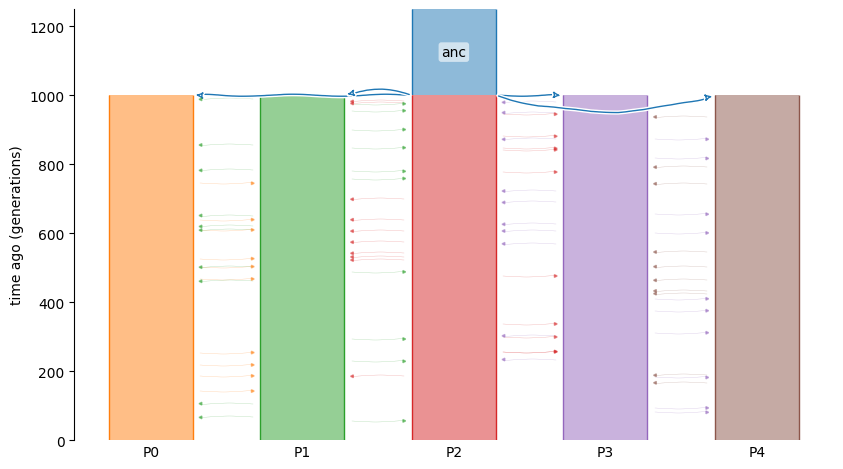

In [1]:
import msprime as msp
import demes
import demesdraw

demo = msp.Demography()
demo.add_population(initial_size = 5000, name = "anc")
demo.add_population(initial_size = 5000, name = "P0")
demo.add_population(initial_size = 5000, name = "P1")
demo.add_population(initial_size = 5000, name = "P2")
demo.add_population(initial_size = 5000, name = "P3")
demo.add_population(initial_size = 5000, name = "P4")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.001)
demo.set_symmetric_migration_rate(populations=("P1", "P2"), rate=0.001)
demo.set_symmetric_migration_rate(populations=("P2", "P3"), rate=0.001)
demo.set_symmetric_migration_rate(populations=("P3", "P4"), rate=0.001)
tmp = [f"P{i}" for i in range(5)]
demo.add_population_split(time = 1000, derived=tmp, ancestral="anc")
g = demo.to_demes()
sample_size = 10
samples = {f"P{i}": sample_size for i in range(5)}
anc = msp.sim_ancestry(samples=samples, demography=demo, recombination_rate=1e-8, sequence_length=1e7, random_seed = 12)
ts = msp.sim_mutations(anc, rate=1e-8, random_seed = 12)

demesdraw.tubes(g)

In [ ]:
from __future__ import annotations

from typing import Any, Dict, List, Mapping, Optional, Sequence, Set, Tuple

import jax
import jax.numpy as jnp
import msprime as msp
from scipy.optimize import LinearConstraint, minimize
import jax.random as jr
from jax import vmap, lax 

from demesinfer.coal_rate import PiecewiseConstant
from demesinfer.constr import EventTree, constraints_for
from demesinfer.iicr import IICRCurve
from demesinfer.loglik.arg import loglik

def compile(ts, subkey):
    # using a set to pull out all unique populations that the samples can possibly belong to
    pop_cfg = {ts.population(ts.node(n).population).metadata["name"] for n in ts.samples()}
    pop_cfg = {pop_name: 0 for pop_name in pop_cfg}

    samples = jax.random.choice(subkey, ts.num_samples, shape=(2,), replace=False)
    a, b = samples[0].item(0), samples[1].item(0)
    spans = []
    curr_t = None
    curr_L = 0.0
    for tree in ts.trees():
        L = tree.interval.right - tree.interval.left
        t = tree.tmrca(a, b)
        if curr_t is None or t != curr_t:
            if curr_t is not None:
                spans.append([curr_t, curr_L])
            curr_t = t
            curr_L = L
        else:
            curr_L += L
    spans.append([curr_t, curr_L])
    data = jnp.asarray(spans, dtype=jnp.float64)
    pop_cfg[ts.population(ts.node(a).population).metadata["name"]] += 1
    pop_cfg[ts.population(ts.node(b).population).metadata["name"]] += 1
    return data, pop_cfg

def get_tmrca_data(ts, key, num_samples):
    data_list = []
    cfg_list = []
    max_indices = []
    for i in range(num_samples):
        key, subkey = jr.split(key)
        data, cfg = compile(ts, subkey)
        data_list.append(data)
        cfg_list.append(cfg)
        max_indices.append(data.shape[0] - 1)

    lens = jnp.array([d.shape[0] for d in data_list], dtype=jnp.int32)
    Lmax = int(lens.max())
    Npairs = len(data_list)
    data_pad = jnp.full((Npairs, Lmax, 2), jnp.array([1.0, 0.0]), dtype=jnp.float64)

    for i, d in enumerate(data_list):
        data_pad = data_pad.at[i, : d.shape[0], :].set(d)

    deme_names = cfg_list[0].keys()
    D = len(deme_names)
    cfg_mat = jnp.zeros((num_samples, D), dtype=jnp.int32)
    for i, cfg in enumerate(cfg_list):
        for j, n in enumerate(deme_names):
            cfg_mat = cfg_mat.at[i, j].set(cfg.get(n, 0))

    unique_cfg = jnp.unique(cfg_mat, axis=0)

    # Find matching indices
    def find_matching_index(row, unique_arrays):
        matches = jnp.all(row == unique_arrays, axis=1)
        return jnp.where(matches)[0][0]

    # Vectorize over all rows in `arr`
    matching_indices = jnp.array([find_matching_index(row, unique_cfg) for row in cfg_mat])
    
    return data_pad, cfg_mat, deme_names, jnp.array(max_indices), unique_cfg, matching_indices
key = jr.PRNGKey(1)
data_pad, cfg_mat, deme_names, max_indices, unique_cfg, matching_indices = get_tmrca_data(ts, key, num_samples=100)
first_columns = data_pad[:, :, 0]
# Compute global max (single float value)
global_max = jnp.max(first_columns)
print(global_max)
t_breaks = jnp.insert(jnp.linspace(1e-8, global_max * 2, 1000), 0, 0.0)

unique_cfg
unique_sample_config = []
for sample_config in unique_cfg:
    ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
    unique_sample_config.append(ns)

90490.35626084449


In [3]:
demesinfer_surv_prob = []
demesinfer_c = []
iicr = IICRCurve(demo=g, k=2)

for ns in unique_sample_config:
    result = iicr(params={}, t=t_breaks, num_samples=ns)
    demesinfer_surv_prob.append(jnp.exp(result["log_s"]))
    demesinfer_c.append(result["c"])

2025-08-16 13:00:10.516 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-16 13:00:10.519 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-16 13:00:10.519 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-16 13:00:10.520 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 3 with attributes {'event': PopulationStart(), 'block': frozenset({'P2'}), 't': ('demes', 3, 'epochs', 0, 'end_time')}
2025-08-16 13:00:10.521 | DEBUG    | demesinfer.event_tree:_add_node:503 - creating node 4 with attributes {'event': PopulationStart(), 'block': frozenset({'P3'}), 't'

In [4]:
debug = demo.debug()

debug_surv_prob = []
debug_c = []
for ns in unique_sample_config:
    result = debug.coalescence_rate_trajectory(t_breaks, ns)
    debug_c.append(result[0])
    debug_surv_prob.append(result[1])

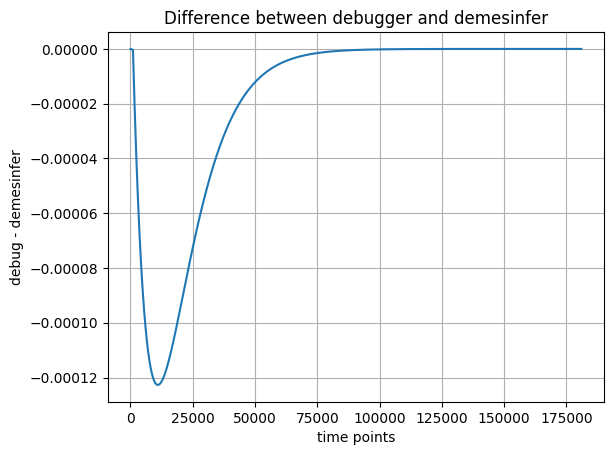

In [5]:
import matplotlib.pyplot as plt
import numpy as np
i = 14
plt.plot(t_breaks, debug_surv_prob[i] - demesinfer_surv_prob[i])         # Plot difference
plt.xlabel('time points')
plt.ylabel('debug - demesinfer')
plt.title('Difference between debugger and demesinfer')
plt.grid(True)  # Optional grid
plt.show()

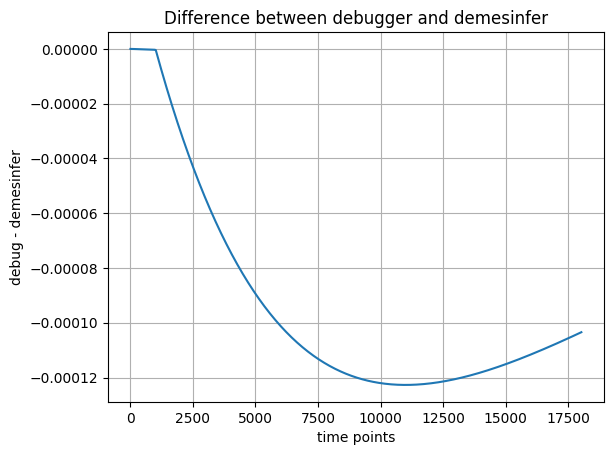

In [16]:
import matplotlib.pyplot as plt
import numpy as np
i = 14
plt.plot(t_breaks[0:500], (debug_surv_prob[i] - demesinfer_surv_prob[i])[0:500])         # Plot difference
plt.xlabel('time points')
plt.ylabel('debug - demesinfer')
plt.title('Difference between debugger and demesinfer')
plt.grid(True)  # Optional grid
plt.show()

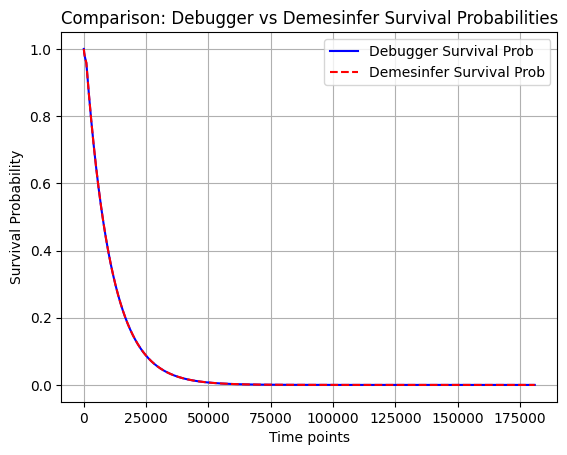

In [15]:
i = 14
plt.plot(t_breaks, debug_surv_prob[i], label='Debugger Survival Prob', linestyle='-', color='blue')
plt.plot(t_breaks, demesinfer_surv_prob[i], label='Demesinfer Survival Prob', linestyle='--', color='red')
plt.xlabel('Time points')
plt.ylabel('Survival Probability')
plt.title('Comparison: Debugger vs Demesinfer Survival Probabilities')
plt.legend()  # Show legend to distinguish lines
plt.grid(True)  # Optional grid
plt.show()

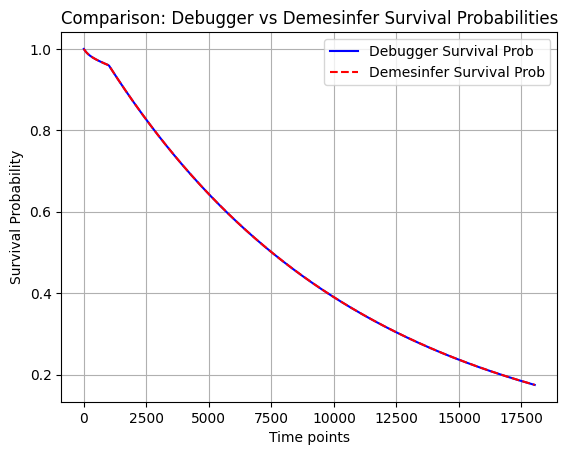

In [14]:
i = 14
plt.plot(t_breaks[0:500], debug_surv_prob[i][0:500], label='Debugger Survival Prob', linestyle='-', color='blue')
plt.plot(t_breaks[0:500], demesinfer_surv_prob[i][0:500], label='Demesinfer Survival Prob', linestyle='--', color='red')
plt.xlabel('Time points')
plt.ylabel('Survival Probability')
plt.title('Comparison: Debugger vs Demesinfer Survival Probabilities')
plt.legend()  # Show legend to distinguish lines
plt.grid(True)  # Optional grid
plt.show()

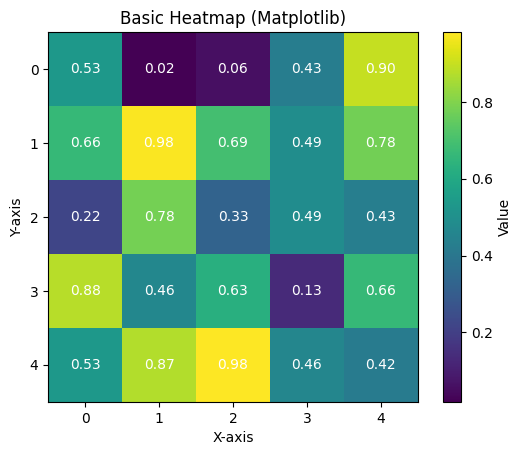

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data (5x5 matrix)
data = np.random.rand(5, 5)

# Create heatmap
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')  # Add colorbar
plt.title("Basic Heatmap (Matplotlib)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Annotate values (optional)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color='white')

plt.show()